In [2]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import os, random
import PIL.Image
import pathlib
import PIL

In [4]:
# importiamo il dataset flower_photos
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True,
                                   cache_dir='.') # questa parte lo scarica dentro la current directory


In [5]:
# analisi del dataset
# conteggio di quante immagini ci sono in ogni classe 

counts = {}
data_dir = os.path.join(os.getcwd(), "datasets", "flower_photos","flower_photos")

for folder in os.listdir(data_dir):
    path = os.path.join(data_dir, folder)
    if os.path.isdir(path):
        num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))])
        counts[folder] = num_files

print(counts) # print del count del dataset

{'daisy': 633, 'dandelion': 898, 'roses': 641, 'sunflowers': 699, 'tulips': 799}


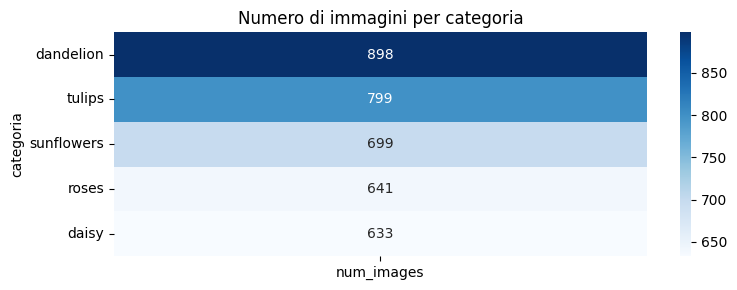

In [6]:
df = pd.DataFrame.from_dict(counts, orient="index", columns=["num_images"])
df.index.name = "categoria"
df = df.sort_values("num_images", ascending=False)

plt.figure(figsize=(8, len(df) * 0.6))
sns.heatmap(df, annot=True, fmt="d", cmap="Blues")
plt.title("Numero di immagini per categoria")
plt.tight_layout()
plt.show()

                 h            w
count  3670.000000  3670.000000
mean    271.791281   365.062398
std      51.743992   116.889715
min     159.000000   143.000000
25%     240.000000   320.000000
50%     240.000000   320.000000
75%     333.000000   500.000000
max     442.000000  1024.000000


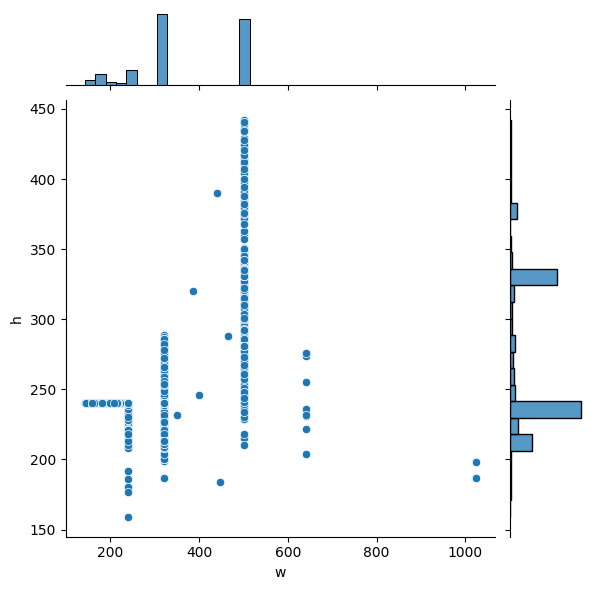

In [7]:
# analisi shape immagini

# 1. Create a TensorFlow dataset from paths
def get_image_dims(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    return tf.shape(img)[:2]  # Returns (height, width)

# Get all image paths
image_paths = []
for classe in os.listdir(data_dir):
    if not classe.endswith('.txt'):
        class_dir = os.path.join(data_dir, classe)
        image_paths.extend([os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Convert to TensorFlow dataset
path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
dims_ds = path_ds.map(get_image_dims, num_parallel_calls=tf.data.AUTOTUNE)

# Get all dimensions
sizes = list(dims_ds.as_numpy_iterator())
h_shape, w_shape = zip(*sizes)

# Create DataFrame
df_shape = pd.DataFrame({"h": h_shape, "w": w_shape})
print(df_shape.describe())


#print(df_shape.head())
sns.jointplot(data=df_shape, x="w", y="h", kind="scatter")
plt.show()

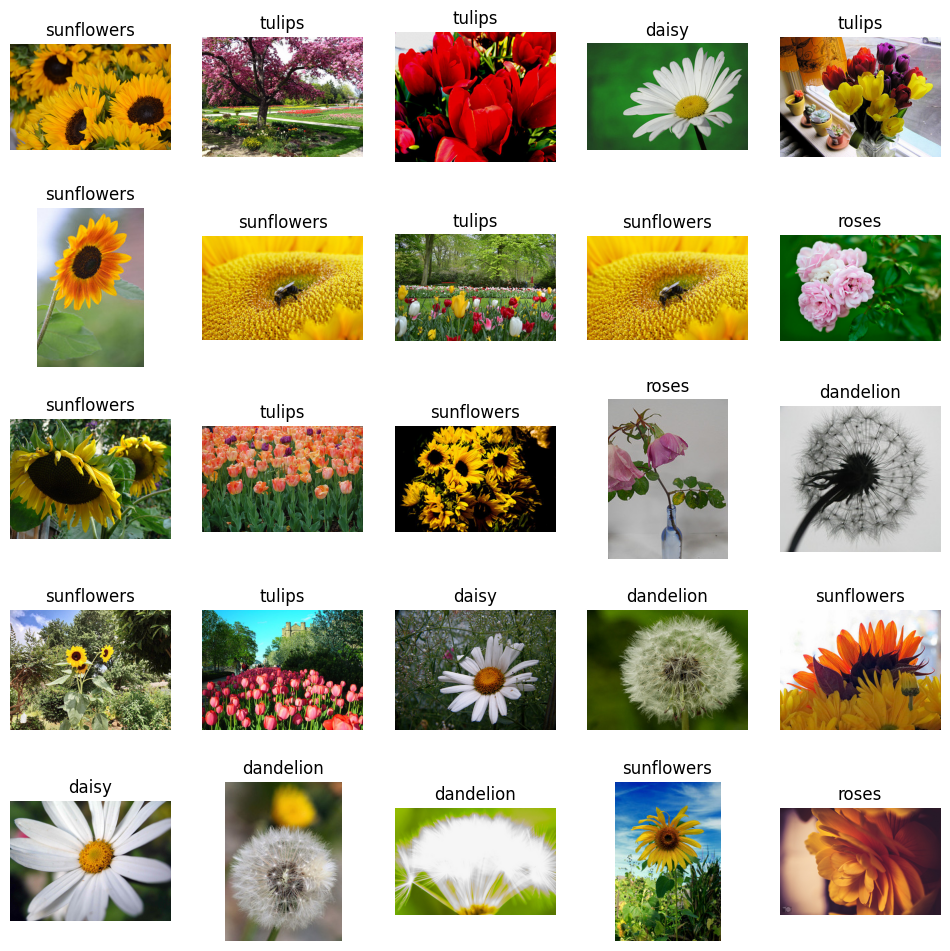

In [8]:
# visualizza alcune immagini
plt.figure(figsize=(12,12))
for i in range(25):
    def choose_random_img(data_dir):
        random_folder = random.choice(os.listdir(data_dir))

        if not random_folder.endswith('.txt'): 
            file_name = random.choice(os.listdir(os.path.join(data_dir, random_folder)))
            path = os.path.join(data_dir, random_folder, file_name)
            img = mpimg.imread(path)
            h, w = img.shape[:2]
            #print(f"shape: {h,w}")
            return plt.subplot(5,5, i+1), plt.imshow(img), plt.axis("off"), plt.title(random_folder)
        
        else:
            choose_random_img(data_dir)

    choose_random_img(data_dir)
plt.show()

In [9]:
# caricato in full_data il dataset di immagini compreso di classi
full_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size= (256,256),
    batch_size=128,
    crop_to_aspect_ratio = True,
    seed=42
)

Found 3670 files belonging to 5 classes.


In [13]:
# === Estrazione delle immagini e delle etichette dal set di training ===
x_train, y_train = [], []  # Liste vuote per immagini e label
for image, label in tfds.as_numpy(full_data):  # Converte i dati in array NumPy
    x_train.append(image)  # Aggiunge l'immagine
    y_train.append(label)  # Aggiunge l'etichetta

'''
# Converte le liste in tensori TensorFlow
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

# Crea un DataFrame pandas con le etichette
df_labels = pd.DataFrame(y_train.numpy(), columns=["label"])

# Conta il numero di occorrenze per ciascuna etichetta
class_distribution = df_labels["label"].value_counts().sort_index()

'''

'\n# Converte le liste in tensori TensorFlow\nX_train = tf.convert_to_tensor(X_train)\ny_train = tf.convert_to_tensor(y_train)\n\n# Crea un DataFrame pandas con le etichette\ndf_labels = pd.DataFrame(y_train.numpy(), columns=["label"])\n\n# Conta il numero di occorrenze per ciascuna etichetta\nclass_distribution = df_labels["label"].value_counts().sort_index()\n\n'

In [ ]:
train_size = int(len(full_data) * 0.8)
val_size = int(len(full_data) * 0.15)
test_size = int(len(full_data) * 0.05)


# passaggio più performante
train_data = full_data.take(train_size)
test_data = full_data.skip(train_size)
val_data = test_data.skip(test_size)
test_data = test_data.take(test_size)

print(f" train data: {len(train_data)}")
print(f" test data: {len(test_data)}")
print(f" val data: {len(val_data)}")

 train data: 23
 test data: 1
 val data: 5


In [ ]:
print(train_data.)

<bound method DatasetV2.cardinality of <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>>


In [ ]:
# optimize 
train_data_prefetched = train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data_prefetched = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_data_prefetched = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3670 files belonging to 5 classes.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
# crea modello
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),
    # data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Conv2D(32, 3, activation="relu"),
    # tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(len(full_data.class_names), activation="softmax")
])

model.summary()

 train data: 80
 test data: 17
 val data: 18


In [ ]:
model.compile(
    optimizer= "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

# Addestra il modello
early_stopping = EarlyStopping(
    monitor ='val_accuracy',                        # Monitora l'accuratezza di validazione
    patience = 5,                                   # Numero di epoche senza miglioramento prima di fermare l'addestramento
    restore_best_weights=True                       # Ripristina i pesi del modello alla migliore versione trovata
)

training = model.fit(
    train_data_prefetched,
    validation_data = val_data_prefetched,
    epochs = 20
)


# salva il modello
model.save("model_flower_256x256.keras")

In [ ]:
# valuto il modello

pd.DataFrame(training.history)[["accuracy", "val_accuracy"]].plot()
plt.title("accuracy e val accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

